In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

<p>$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}$
$\newcommand{\indic}{\mathbb{1}}$
$\newcommand{\avg}{\overline}$
$\newcommand{\est}{\hat}$
$\newcommand{\trueval}[1]{#1^{*}}$
$\newcommand{\Gam}[1]{\mathrm{Gamma}#1}$</p>

<h2 id="data-on-the-birth-of-babies">Data on the birth of babies</h2>

<blockquote>
  <p>Forty-four babies – a new record – were born in one 24-hour period at
the Mater Mothers’ Hospital in Brisbane, Queensland, Australia, on
December 18, 1997.  For each of the 44 babies, <em>The Sunday Mail</em>
recorded the time of birth, the sex of the child, and the birth weight
in grams. Also included is the number of minutes since midnight for
each birth.</p>
</blockquote>

<p>REFERENCE:
Steele, S. (December 21, 1997), “Babies by the Dozen for Christmas:
24-Hour Baby Boom,” <em>The Sunday Mail</em> (Brisbane), p. 7.</p>

<p>“Datasets
and Stories” article “A Simple Dataset for Demonstrating Common
Distributions” in the <em>Journal of Statistics Education</em> (Dunn 1999).</p>

<p>Columns</p>

<div class="highlighter-rouge"><div class="highlight"><pre class="highlight"><code>   1 24hrtime  Time of birth recorded on the 24-hour clock
   2 sex  Sex of the child (1 = girl, 2 = boy)
   3 weight  Birth weight in grams
   4 minutes  Number of minutes after midnight of each birth
</code></pre></div></div>

In [4]:
df = pd.read_csv("data/babyboom.dat.txt", header=None, sep='\s+', names=['24hrtime','sex','weight','minutes'])
df.head()

,24hrtime,sex,weight,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


We find it convenient to group births into the hours of the day during which they occurred. Let’s bin minutes in order to construct a new feature ‘hours’ and store in it the number of births in each hour.

In [5]:
df['hours'] = df.minutes // 60
df.head()

,24hrtime,sex,weight,minutes,hours
0,5,1,3837,5,0
1,104,1,3334,64,1
2,118,2,3554,78,1
3,155,2,3838,115,1
4,257,2,3625,177,2


<h3 id="frequentist-philosophy--samples-vs-population">Frequentist Philosophy:  Samples vs population</h3>

<p>We’ve started out this lab by presenting you with some data.  What are we to do with the data?  What are some reasonable approaches to handling the data in such a way that we can draw insights and render conclusions based on the data.  <strong>Frequentist inference</strong> is one framework which serves to constructively provide answers to these sorts of questions.  According to Wikipedia</p>

<blockquote>
  <p>Frequentist inference has been associated with the frequentist interpretation of probability, specifically that any given experiment can be considered as one of an infinite &gt; sequence of possible repetitions of the same experiment, each capable of producing statistically independent results. In this view, the frequentist inference approach to &gt; drawing conclusions from data is effectively to require that the correct conclusion should be drawn with a given (high) probability, among this notional set of repetitions.</p>
</blockquote>

<p>The main idea is that given a set of data, frequentism conceives of that data as one <strong>sample</strong> from an existing <strong>population</strong> that comes about from a <strong>data generating process</strong>.  That sample can be used to draw inferences about the population.  This data generating process can be repeated over and over again to create other (slightly different) samples each of which can similarly used conclusions about the population.</p>

<p>This notion is probably clearest to you from elections, where some companies like Zogby or CNN take polls. The sample in these polls may be some finite population (e.g. 1000 people) but that sample is used to  “represent” the electoral population at large. the pollsters can then attempt to draw inferences about how the population will vote based on the samples and use the tools of frequentist intervals to provide guidance about the robustness of their conclusions.</p>

<p>The main purpose of this lab is to introduce <strong>Frequentism</strong> and help familiarize you with some common frequentist tools.</p>

<h3 id="the-idealized-data-generating-process">The Idealized Data-Generating Process</h3>

<p>Let’s examine the frequentist paradigm under “ideal circumstances”.  We’ll skip over (or present without explanation) some concepts and terminology as the idea here is to provide you intuition and motivate some of the tools we’ll present later.</p>

<ol>
  <li>
    <p>We’re provided with our data sample $S = {X_1, X_2, …, X_k}$</p>
  </li>
  <li>
    <p>We calculate our relevant estimate(s) or statistic(s) on that sample</p>
  </li>
  <li>
    <p>In order to generate confidence intervals around our estimate(s) or statistic(s) we generate from the data generating process n additional data samples</p>
  </li>
  <li>
    <p>On each of those n data samples we repeat the calculations of the estimate(s) or statistic(s)</p>
  </li>
  <li>
    <p>Collectively use the calculated estimate(s)/statistic(s) on the generated samples to construct a confidence interval</p>
  </li>
</ol>

<p>Our inference is our original estimate(s)/statistic(s) and the constructed confidence intervals from the estimate(s)/statistic(s) from our n samples from the data generating process</p>

<h3 id="example-of-the-idealized-data-generating-process-male-heights">Example of the Idealized Data Generating Process: Male Heights</h3>

<p>Let’s say we know that male heights follow a Gaussian distribution with mean 70 inches and standard deviation 4 inches.  Consider the following two data samples drawn from the canonical distribution of male heights.  For each sample use the idealized data generating process to estimate the mean male height using n=100 additional samples to generate confidence intervals.</p>

<p><strong>We’re provided our data sample</strong></p>

In [7]:
male_heights_sample1 = np.array([65.27156778, 70.54877119, 73.3194762 , 65.39765796, 71.20531282,
       72.60242314, 71.37226406, 68.32409185, 74.53513439, 74.55146588,
       68.66712633, 72.94632781, 67.53369738, 71.91086708, 67.04768347,
       73.93720054, 77.83917981, 73.05772208, 63.5739442 , 70.95335019])

male_heights_sample2 = np.array([73.5832399 , 72.20626275, 76.19045706, 67.57730802, 74.77351658,
       85.43682136, 73.38080912, 75.71094703, 70.59903148, 73.5543091 ,
       71.76435781, 69.27927312, 66.54357112, 74.31531105, 76.68361655,
       69.36297994, 75.18045033, 71.16446918, 74.43549175, 68.72731837])

In [8]:
print("Estimated mean male height from sample 1: ", np.mean(male_heights_sample1))

Estimated mean male height from sample 1:  70.729763208


In [9]:
print("Estimated mean male height from sample 2: ", np.mean(male_heights_sample2))

Estimated mean male height from sample 2:  73.023477081


Generate n=100 additional data samples from the Data Generating Process

In [10]:
additional_heights = scipy.stats.norm.rvs(loc=70, scale=4, size=(100,20))

Repeat Calculation of estimate on each of the n=100 additional data samples from the Data Generating Process

In [11]:
additional_heights_estimates = np.mean(additional_heights, axis=1)

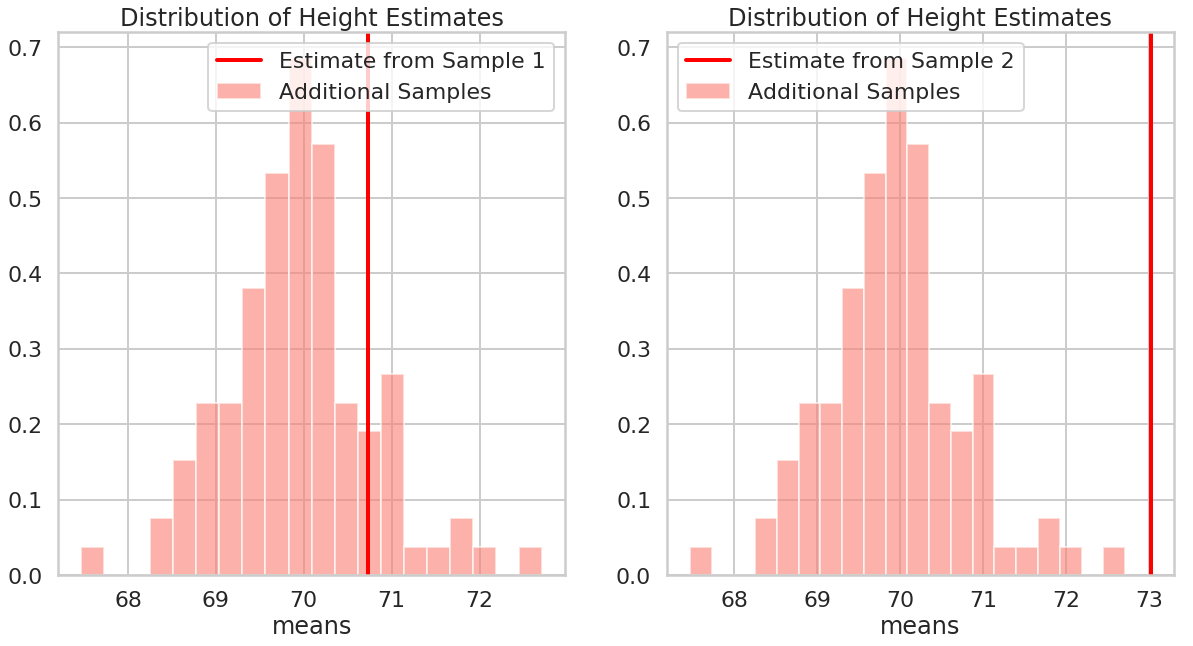

In [12]:
def viz_estimates(viz_axis, viz_data, viz_label, viz_color,  x_label, viz_title, sample_estimate, estimate_label, bin_count=20):

        
    #plot histogram
    _, viz_bins, _ = viz_axis.hist(viz_data, bins=bin_count, facecolor=viz_color, edgecolor='white', label="Additional Samples", density=True, alpha=0.6)

    viz_axis.axvline(x=sample_estimate, linewidth=4, color='r', label=estimate_label)
    viz_axis.set_xlabel(x_label)
    viz_axis.set_title(viz_title)
    viz_axis.legend(loc='best')
    
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

viz_estimates(
    ax1,
    additional_heights_estimates,
    'Estimates of Additional Height Samples',
    'salmon',
    'means',
    'Distribution of Height Estimates',
    np.mean(male_heights_sample1),
    'Estimate from Sample 1'
)

viz_estimates(
    ax2,
    additional_heights_estimates,
    'Estimates of Additional Height Samples',
    'salmon',
    'means',
    'Distribution of Height Estimates',
    np.mean(male_heights_sample2),
    'Estimate from Sample 2'
)

Are the true value of the parameter for the data generating model in the 95% confidence intervals?

In [13]:
heights_percentile_interval = np.percentile(additional_heights_estimates, [2.5, 97.5])

heights_percentile_interval -= heights_percentile_interval[0]

heights_percentile_interval -= heights_percentile_interval[1]/2

In [14]:
print("95% confidence interval sample 1: ", np.mean(male_heights_sample1)+ heights_percentile_interval)

95% confidence interval sample 1:  [69.08559572 72.37393069]


In [15]:
print("95% confidence interval sample 2: ", np.mean(male_heights_sample2)+ heights_percentile_interval)

95% confidence interval sample 2:  [71.3793096  74.66764457]


We happen to know the true parameters of the model for the data generating process and the mean for that model isn’t in the 95% confidence interval for male heights sample 2.

<h2 id="choosing-a-model-the-exponential-distribution">Choosing a model: the exponential distribution</h2>

<p>Going back to the baby data that we were given at the beginning of lab, what would a natural choice for the probability distribution for the data generating process for the babies?</p>

<p>One possibility is exponential distribution which comes up naturally when describing the lengths of the inter-arrival times in a homogeneous Poisson process.</p> It takes the form:

$$
f(x;\lambda) = \begin{cases}
\lambda e^{-\lambda x} & x \ge 0, \\
0 & x < 0.\end{cases}
$$

<p>From Wikipedia: <em>In probability theory, a Poisson process is a stochastic process which counts the number of events and the time that these events occur in a given time interval. The time between each pair of consecutive events has an exponential distribution with parameter $\lambda$ and each of these inter-arrival times is assumed to be independent of other inter-arrival times. The process is named after the French mathematician Siméon Denis Poisson and is a good model of radioactive decay, telephone calls and requests for a particular document on a web server, among many other phenomena.</em></p>

<p>In our example above, we have the arrival times of the babies. There is no reason to expect any specific clustering in time, so one could think of modelling the arrival of the babies via a poisson process.</p>

<p>Furthermore, the Poisson distribution can be used to model the number of births each hour over the 24-hour period.</p>

<h3 id="what-does-the-exponential-distribution-look-like">What does the exponential distribution look like?</h3>

Text(0, 0.5, 'exponential pdf')

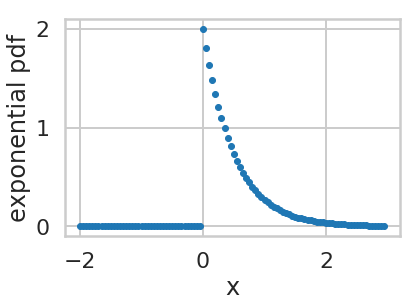

In [16]:
f = lambda x, l: l*np.exp(-l*x)*(x>0)
xpts=np.arange(-2,3,0.05)
plt.plot(xpts,f(xpts, 2),'.');
plt.xlabel("x")
plt.ylabel("exponential pdf")

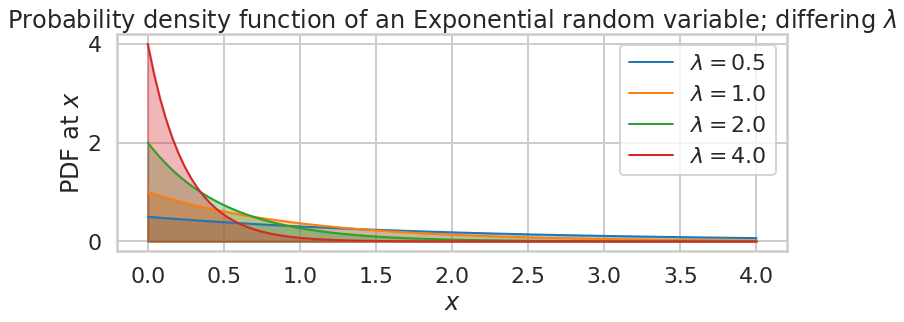

In [17]:
from scipy.stats import expon

x = np.linspace(0,4, 100)
colors=sns.color_palette()

lambda_ = [0.5, 1, 2, 4]
plt.figure(figsize=(12,4))
for l,c in zip(lambda_,colors):
    plt.plot(x, expon.pdf(x, scale=1./l), lw=2, 
                color=c, label = "$\lambda = %.1f$"%l)
    plt.fill_between(x, expon.pdf(x, scale=1./l), color=c, alpha = .33)
    
plt.legend()
plt.ylabel("PDF at $x$")
plt.xlabel("$x$")
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

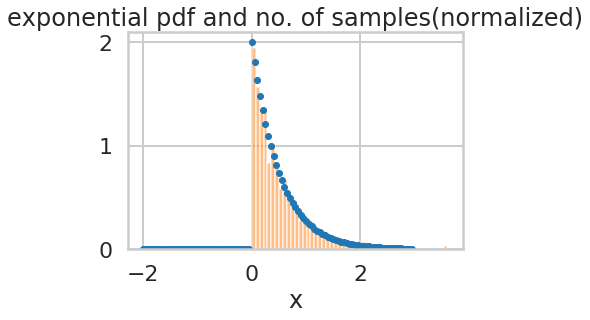

In [18]:
from scipy.stats import expon
plt.plot(xpts,expon.pdf(xpts, scale=1./2.),'.')
plt.hist(expon.rvs(size=1000, scale=1./2.), density=True, alpha=0.5, bins=50);
plt.xlabel("x")
plt.title("exponential pdf and no. of samples(normalized)");

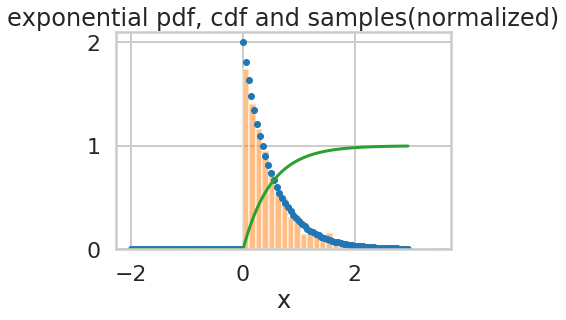

In [19]:
rv = expon(scale=0.5)
plt.plot(xpts,rv.pdf(xpts),'.')
plt.hist(rv.rvs(size=1000), density=True, alpha=0.5, bins=30);
plt.plot(xpts, rv.cdf(xpts));
plt.xlabel("x")
plt.title("exponential pdf, cdf and samples(normalized)");

<h2 id="the-poisson-distribution">The Poisson distribution</h2>

<p>The Poisson distribution is a discrete distribution, it expresses the probability of a given number of events occurring in a fixed interval of time (or space, volume, etc.). One assumption made is that these events occur with a known average rate and independently of each other. An example is the number of electrons detected by a sensor in an electron microscope during a time interval, or the number of soldiers in the Prussian army killed accidentally by horse kicks <a href="http://en.wikipedia.org/wiki/Poisson_distribution">(see here)</a>.</p>

<p>The Poisson distribution is defined as:</p>

$$f(k; \mu)= \frac{\mu^k e^{-\mu}}{k!}$$

<p>where $k$ is the number of events, $\mu$ is a positive real number, and $e$ is Euler’s number ($e = 2.71828 \ldots$).</p>

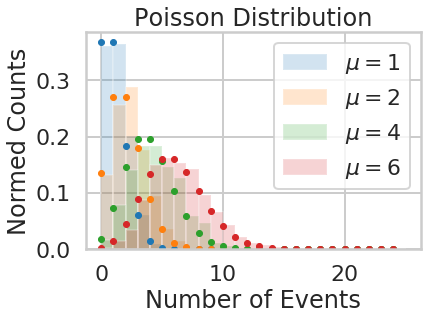

In [20]:
from scipy.stats import poisson
# generate samples for different values of mu
kpts=np.arange(0,25)
for mu, c in zip([1,2, 4, 6], sns.color_palette()[:4]):
    randomVariates = poisson.rvs(mu, size=1000)
    plt.hist(randomVariates, density=True, color=c, alpha=0.2, bins=range(0,26), label='$\mu=' + np.str(mu) + '$')
    plt.plot(kpts, poisson.pmf(kpts, mu), '.', color=c)

plt.legend()
plt.title("Poisson Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Normed Counts");

<h3 id="understanding-our-data-using-a--histogram-plotted-distribution">Understanding our data using a  histogram-plotted distribution</h3>

<p>Lets play with our data a bit to understand it:</p>

<p>The first birth occurred at 0005, and the last birth in the 24-hour period at 2355. Thus the 43 inter-birth times happened over a 1430-minute period, giving a theoretical mean of 1430/43 = 33.26 minutes between births.</p>

<p>Lets plot a histogram of the inter-birth times</p>

33.25581395348837


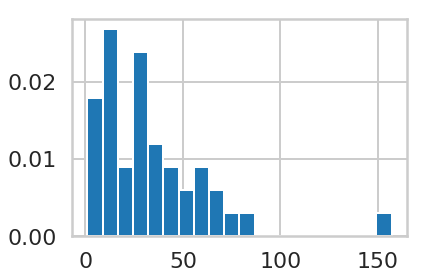

In [21]:
timediffs = df.minutes.diff()[1:]
print(timediffs.mean())
timediffs.hist(bins=20, density=True);

In [22]:
poiskcount = df.groupby('hours')['minutes'].count()
poiskcount

hours
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

Since the Poisson is a discrete distribution, it has a probability mass function. Normalizing a pdf is not what we want here, rather, the values of the pmf (which are probabilities) should sum to 1. So we take matters into our own hands.

We make sure that every point has equal mass, so that the total mass is one. Then the mass at any point depends on how many samples (the count) we have for it.

(array([8., 0., 0., 6., 0., 0., 4., 0., 0., 3.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

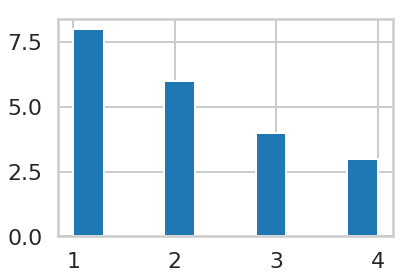

In [23]:
weights = np.ones_like(poiskcount)/len(poiskcount)
plt.hist(poiskcount)


<h3 id="maximum-likelihood-estimation">Maximum Likelihood Estimation</h3>

<p>As described in detail above, in frequentist statistics, the data we have in hand, is viewed as a <strong>sample</strong> from a population. So if we want to estimate some parameter of the population, like say the mean, we estimate it on the sample.</p>

<p>This is because we’ve been given only one sample. Ideally we’d want to see the population, but we have no such luck.</p>

<p>The parameter estimate is computed by applying an estimator $F$ to some data $D$, so $\est{\lambda} = F(D)$.</p>

<p>**The parameter is viewed as fixed and the data as random, which is the exact opposite of the Bayesian approach which you will learn later in this class. **</p>

<p>In the “ideal circumstances”, we knew the true values of the parameters for the probability model for the data generating process and though we were given one sample, we can generate additional samples that we are guaranteed to be from the same distribution as the population at will.  Unfortunately we don’t generally reside in ideal circumstances and although we may know the distributional family of the probability model generating the data, we don’t know a priori its true parameters.  We need to come up with a way of finding/guessing/estimating those parameters.  One of the techniques used to estimate such parameters in frequentist statistics is <strong>maximum likelihood estimation</strong>. Briefly, the idea behind it is:</p>

<p>The product</p>

<script type="math/tex; mode=display">L(\lambda) = \prod_{i=1}^n P(x_i \mid \lambda)</script>

<p>gives us a measure of how likely it is to observe values $x_1,…,x_n$ given the parameters $\lambda$. Maximum likelihood fitting consists of choosing the appropriate “likelihood” function $L=P(X \mid \lambda)$ to maximize for a given set of observations. How likely are the observations if the model is true?</p>

<p>Often it is easier and numerically more stable to maximise the log likelyhood:</p>

<script type="math/tex; mode=display">\ell(\lambda) = \sum_{i=1}^n ln(P(x_i \mid \lambda))</script>

<h3 id="analytic-mle-for-the-exponential-distribution">Analytic MLE for the Exponential distribution</h3>

<p>In the case of the exponential distribution we have:</p>

<script type="math/tex; mode=display">\ell(lambda) = \sum_{i=1}^n ln(\lambda e^{-\lambda x_i}) = \sum_{i=1}^n \left( ln(\lambda) - \lambda x_i \right).</script>

<p>Maximizing this:</p>

<script type="math/tex; mode=display">\frac{d \ell}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^n x_i = 0</script>

<p>and thus:</p>

<script type="math/tex; mode=display">\frac{1}{\est{\lambda_{MLE}}} = \frac{1}{n}\sum_{i=1}^n x_i,</script>

<p>which is identical to the simple estimator we used above. Usually one is not so lucky and one must use numerical optimization techniques.</p>

<p>For the babies, we’re assuming that an exponential distribution is a good description of the baby arrival process. When we consider the larger population of babies from our sample of baby arrival data is drawn, there is some true $\trueval{\lambda}$ which defines it. We dont know this true $\trueval{\lambda}$. The best we can do to start with is to estimate a lambda from the data set we have, which we denote $\est{\lambda}$ and in some sense the MLE estimate is the “best” estimate.</p>

<p>This makes intuitive sense: if you get babies at an average rate of 2 per hour, then you can expect to wait half an hour on average for every baby.</p>

In [24]:
lambda_from_mean = 1./timediffs.mean()
print(lambda_from_mean, 1./lambda_from_mean)

0.03006993006993007 33.25581395348837


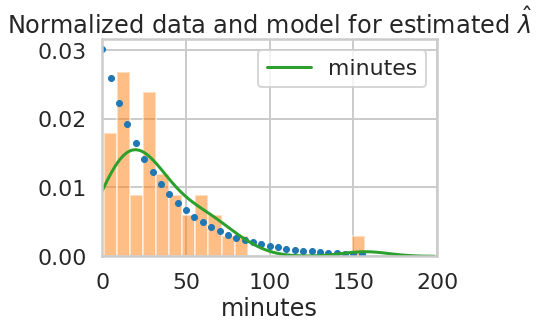

In [25]:
minutes=np.arange(0, 160, 5)
rv = expon(scale=1./lambda_from_mean)
plt.plot(minutes,rv.pdf(minutes),'.')
timediffs.hist(density=True, alpha=0.5, bins=20);
sns.kdeplot(timediffs)
plt.xlabel("minutes");
plt.xlim([0,200])
plt.title("Normalized data and model for estimated $\hat{\lambda}$");


<p>What did we just do? We made a ‘point estimate’ of the scale or rate parameter as a compression of our data.</p>

<h3 id="for-poisson">For Poisson</h3>

<p>In the case of the poisson distribution we have:</p>

<script type="math/tex; mode=display">\ell(lambda) = \sum_{i=1}^n \left( k_i ln(\mu) - \mu - ln(k_i!) \right).</script>

<p>You maximize this now.</p>

<p><em>your answer here</em></p>

<p>Maximizing this:</p>

<script type="math/tex; mode=display">\frac{d \ell}{d\mu} = \frac{1}{\mu}\sum_{i=1}^n k_i - n = 0</script>

<p>and thus:</p>

<script type="math/tex; mode=display">\est{\mu_{MLE}} = \frac{1}{n}\sum_{i=1}^n k_i</script>

<p>or just the sample mean!</p>

<h3 id="sampling-distribution-of-the-estimator">Sampling Distribution of the Estimator</h3>

<p>Now, imagine that I let you peek at the entire population in this way: I gave you some M data sets <strong>drawn</strong> from the population, and you can now find the mean on each such dataset, of which the one we have here is one.
So, we’d have M means. You can think of these means as coming from some fixed parameter by some data drawing process</p>

<p>Thus if we had many replications of this data set: that is, data from other days, an <strong>ensemble</strong> of data sets, for example, we can compute other $\est{\lambda}$, and begin to construct the <strong>sampling distribution</strong> of $\lambda$.  That’s the scenario we constructed in the “ideal case”.  As you saw above, we can use the sampling distribution to put confidence intervals on the estimation of the parameters.</p>

<p>So, in the babies case, the uncertainty in the parameter estimate can be measured by computing the <strong>sampling distribution</strong> of the estimator. 
What you are doing is sampling many Data Sets $D_i$ from the true population (which we are not given you will argue, and you are right, but just wait a bit), say M of them, each of size N, from some true model $p(\cdot|\trueval{\lambda})$. We will now calculate M $\est{\lambda}_i$, one for each dataset. As we let $M \rightarrow \infty$, the distribution induced on $\est{\lambda}$ is the sampling distribution of the estimator.</p>

<h3 id="bootstrapping">Bootstrapping</h3>

<p>Bootstrap tries to approximate our sampling distribution. If we knew the true parameters of the population, we could generate M fake datasets. Then we could compute the parameter (or another estimator) on each one of these, to get a empirical sampling distribution of the parameter or estimator, and which will give us an idea of how typical our sample is, and thus, how good our parameter estimations from our sample are.
(again from murphy)</p>

<p>But we dont have the true parameter. So we generate these samples, using the parameter we calculated. Or, alteratively, we sample with replacement the X from our original sample D, generating many fake datasets, and then compute the distribution on the parameters as before.</p>

<p>We do it here for the mean of the time differences. We could also do it for its inverse, $\lambda$.</p>

<h3 id="parametric-bootstrapping">Parametric Bootstrapping</h3>

<p>Let’s start with the parametric case.  It’s the one that maps most closely to the ideal case we dealt with above.  We follow the exact same recipe as we did for the ideal data generating process, but since we don’t know the true parameters, we use instead the parameters we obtain from the MLE.  In the case of baby arrival, we get an “estimate” of the parameter from our sample, use the exponential distribution to generate many datasets, and then fit the parameter on each one of those datasets. We can then plot the distribution of the mean time-difference.</p>

<h3 id="the-parametric-bootstrapping-process">The Parametric Bootstrapping Process</h3>

<ol>
  <li>
    <p>We’re provided with our data sample $S = {X_1, X_2, …, X_k}$</p>
  </li>
  <li>
    <p>We calculate our relevant estimate(s) or statistic(s) on that sample</p>
  </li>
  <li>
    <p>In order to generate confidence intervals around our estimate(s) or statistic(s) we generate from the data generating process n additional data samples <strong>using the MLE parameters instead of the “true parameters” (which we don’t know).</strong></p>
  </li>
  <li>
    <p>On each of those n data samples we repeat the calculations of the estimate(s) or statistic(s)</p>
  </li>
  <li>
    <p>Collectively use the calculated estimate(s)/statistic(s) on the generated samples to construct a confidence interval</p>
  </li>
</ol>

<p>Our inference is our original estimate(s)/statistic(s) and the constructed confidence intervals from the estimate(s)/statistic(s) from our n samples from the data generating process</p>

<h3 id="example-of-parametric-bootstrapping-baby-arrival">Example of Parametric Bootstrapping: Baby Arrival</h3>

<p>Let’s apply the process above for our baby arrival dataset.</p>

<p><strong>We’re provided our data sample</strong></p>


In [26]:
baby_arrival_times = timediffs.values

baby_arrival_times

array([ 59.,  14.,  37.,  62.,  68.,   2.,  15.,   9., 157.,  27.,  37.,
         2.,  55.,  86.,  14.,   4.,  40.,  36.,  47.,   9.,  61.,   1.,
        26.,  13.,  28.,  77.,  26.,  45.,  25.,  18.,  29.,  15.,  38.,
         2.,   2.,  19.,  27.,  14.,  13.,  19.,  54.,  70.,  28.])

In [27]:
print("Estimated lambda parameter for baby arrival using analytic MLE approximation: ", np.mean(baby_arrival_times))

Estimated lambda parameter for baby arrival using analytic MLE approximation:  33.25581395348837


In [28]:
additional_arrival_samples = scipy.stats.expon.rvs(scale=np.mean(baby_arrival_times), size=(10000,len(baby_arrival_times)))


In [29]:
additional_arrival_estimates = np.mean(additional_arrival_samples, axis=1)


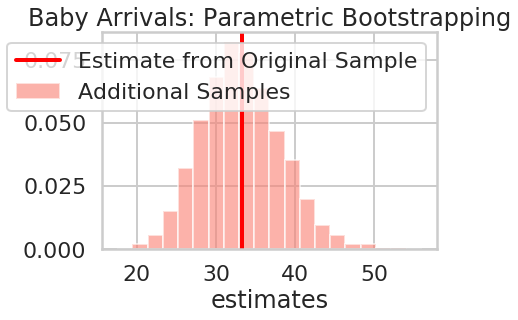

In [30]:
fig, ax = plt.subplots()

viz_estimates(
    ax,
    additional_arrival_estimates,
    'Estimates of Additional Baby Arrival Samples',
    'salmon',
    'estimates',
    'Baby Arrivals: Parametric Bootstrapping',
    np.mean(baby_arrival_times),
    'Estimate from Original Sample'
)

In [31]:
arrivals_percentile_interval = np.percentile(additional_arrival_estimates, [2.5, 97.5])

arrivals_percentile_interval -= arrivals_percentile_interval[0]

arrivals_percentile_interval -= arrivals_percentile_interval[1]/2

In [32]:
print("95% confidence interval sample 1: ", arrivals_percentile_interval+ np.mean(baby_arrival_times))


95% confidence interval sample 1:  [23.34151454 43.17011337]


<h3 id="non-parametric-bootstrapping">Non Parametric Bootstrapping</h3>

<p>In the earlier cases we were pretty confident of the underlying statistical model of the data generating process.  We could at least pin it down within a distribution family.  What about the cases where we’re not really clear about the distribution of data?  What process can we follow in those cases?  We can still engage in bootstrapping, but instead of using estimated MLE parameters and the purported probability distribution of the data-generating process to construct additional samples, we can create the samples by <strong>resampling directly from the data in the original sample</strong>.  The idea (discovered in 1982 by Zac Effron) is that the data in the original sample is a good representation of the population.  If we sample with replacement from the original, our mewly generated samples should come from the same data generating process as the original.  How do we go about this process?</p>

<ul>
  <li>Create new samples by sampling with replacement from the original sample</li>
  <li>Each new sample is called <strong>bootsrap replication</strong></li>
  <li>Each replication should be the same size as the original sample</li>
</ul>

<h3 id="the-non-parametric-bootstrapping-process">The Non-Parametric Bootstrapping Process</h3>

<ol>
  <li>
    <p>We’re provided with our data sample $S = {X_1, X_2, …, X_k}$</p>
  </li>
  <li>
    <p>We calculate our relevant estimate(s) or statistic(s) on that sample <strong>sampling with replacement with the sample size equal to the original sample.</strong></p>
  </li>
  <li>
    <p>On each of those n data samples we repeat the calculations of the estimate(s) or statistic(s)</p>
  </li>
  <li>
    <p>Collectively use the calculated estimate(s)/statistic(s) on the generated samples to construct a confidence interval</p>
  </li>
</ol>

<p>Our inference is our original estimate(s)/statistic(s) and the constructed confidence intervals from the estimate(s)/statistic(s) from our n samples from the data generating process</p>

<h3 id="example-of-non-parametric-bootstrapping-baby-arrival">Example of Non-Parametric Bootstrapping: Baby Arrival</h3>

<p>Let’s apply the process above for our baby arrival dataset.</p>

<p><strong>We’re provided our data sample (this is the same as the parametric and idealized case)</strong></p>

<div class="language-python highlighter-rouge"><div class="highlight"><pre class="highlight"><code><span class="c"># baby_arrival_times = timediffs.values</span>

<span class="c"># baby_arrival_times</span>
</code></pre></div></div>

<p><strong>Calculate estimates on data samples (this is the same as the parametric and idealized case)</strong></p>

In [33]:
print("Estimated lambda parameter for baby arrival using analytic MLE approximation: ", np.mean(baby_arrival_times))


Estimated lambda parameter for baby arrival using analytic MLE approximation:  33.25581395348837


In [34]:
additional_arrival_samples_np = np.random.choice(timediffs.values, size=(10000,len(baby_arrival_times)), replace=True)


In [35]:
additional_arrival_estimates_np = np.mean(additional_arrival_samples_np, axis=1)
additional_arrival_estimates_np

array([33.39534884, 35.18604651, 31.11627907, ..., 32.46511628,
       30.72093023, 38.6744186 ])

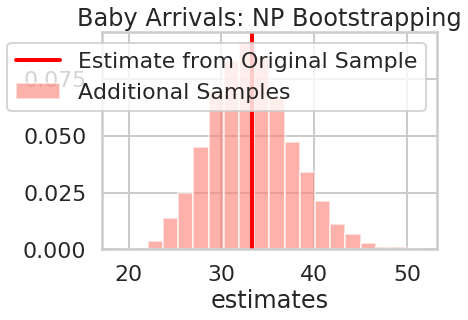

In [36]:
fig, ax = plt.subplots()

viz_estimates(
    ax,
    additional_arrival_estimates_np,
    'Estimates of Additional Baby Arrival Samples',
    'salmon',
    'estimates',
    'Baby Arrivals: NP Bootstrapping',
    np.mean(baby_arrival_times),
    'Estimate from Original Sample'
)


In [37]:
arrivals_percentile_interval_np = np.percentile(additional_arrival_estimates_np, [2.5, 97.5])

arrivals_percentile_interval_np -= arrivals_percentile_interval_np[0]

arrivals_percentile_interval_np -= arrivals_percentile_interval_np[1]/2
print("95% confidence interval sample: ", arrivals_percentile_interval_np+ np.mean(baby_arrival_times))


95% confidence interval sample:  [24.41860465 42.09302326]



<h3 id="when-does-bootstrapping-do-poorly-and-well">When does Bootstrapping Do Poorly (and Well)</h3>

<ul>
  <li>Parametric Bootstrapping will converge to the wrong results if you use the wrong data generating process model</li>
  <li>Parametric Bootstrapping will converge faster if you use an appropriately specified model</li>
  <li>Bootstrapping in general assumes that the estimates/statistics that you calculate aren’t sensitive to small changes in the bootstrapping process
    <ul>
      <li>For parametric bootstrapping small changes in the parameters –&gt; small changes in the sampling distribution</li>
      <li>For non-parametric bootstrapping small changes in the data points (addition or removal) –&gt; small cahanges in the sampling distribution</li>
      <li>For non-parametric be careful with outliers.</li>
    </ul>
  </li>
</ul>
